In [2]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


/home/kai/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kai/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kai/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kai/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

In [3]:
FAST_RUN = False
IMAGE_WIDTH=275
IMAGE_HEIGHT=267
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3  # set to 1

In [4]:
# filter noised pictures
df_defect_filtered = pd.read_csv('data/defect_area.csv')
df_defect = pd.DataFrame({
    'id': df_defect_filtered['id'],
    'defect_score': 1
})

for i in range(len(df_defect)):
    df_defect.loc[i,'id'] = 'defect/'+ df_defect.loc[i,'id']+ '.bmp'

# df_defect.head()
# df_defect.tail()

In [5]:
filenames = os.listdir("data/train/train_contest/good_all")

df_good_all = pd.DataFrame({
    'id': filenames,
    'defect_score': 0
})

for i in range(len(filenames)):
    df_good_all.loc[i,'id'] = 'good_all/'+ df_good_all.loc[i,'id']
    
# df_good_all.head()
# df_good_all.tail()

In [6]:
# df_train_all = pd.concat([df_defect, df_good_all])
df_train_all = pd.concat([df_good_all, df_defect, df_defect, df_defect, df_defect])

# model

In [7]:
model = Sequential()

model.add(Conv2D(16, (3, 3), padding="same", activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have defect and good classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 275, 267, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 275, 267, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 137, 133, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 137, 133, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 137, 133, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 137, 133, 32)      128       
____

In [8]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

# Training data

In [9]:
df_train_all["defect_score"] = df_train_all["defect_score"].replace({0: 'good_all', 1: 'defect'}) 

In [10]:
df_train, df_validate = train_test_split(df_train_all, test_size=0.10, random_state=42)

df_train = df_train.reset_index(drop=True)
df_validate = df_validate.reset_index(drop=True)

In [11]:
df_train.shape, df_validate.shape

((48783, 2), (5421, 2))

<AxesSubplot:>

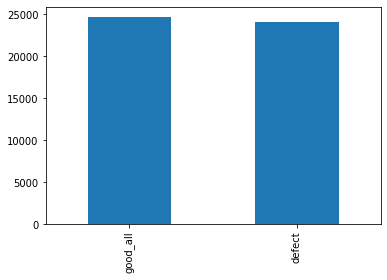

In [12]:
df_train['defect_score'].value_counts().plot.bar()

<AxesSubplot:>

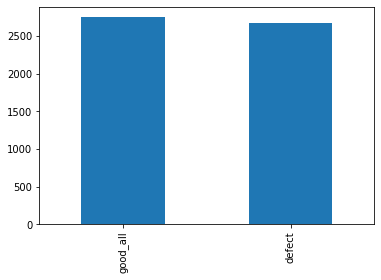

In [13]:
df_validate['defect_score'].value_counts().plot.bar()

In [14]:
total_train = df_train.shape[0]
total_validate = df_validate.shape[0]
batch_size=100

# Traning Generator

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=0,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    df_train, 
    "data/train/train_contest", 
    x_col='id',
    y_col='defect_score',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 48783 validated image filenames belonging to 2 classes.


In [16]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    df_validate, 
    "data/train/train_contest", 
    x_col='id',
    y_col='defect_score',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 5421 validated image filenames belonging to 2 classes.


In [17]:
# df_example = df_train.sample(n=1).reset_index(drop=True)

# example_generator = train_datagen.flow_from_dataframe(
#     df_example, 
#     "data/train/train_contest", 
#     x_col='id',
#     y_col='defect_score',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical'
# )

In [18]:
# plt.figure(figsize=(12, 12))

# for i in range(0, 15):
#     plt.subplot(5, 3, i+1)
#     for X_batch, Y_batch in example_generator:
#         image = X_batch[0]
#         plt.imshow(image)
#         break
# plt.tight_layout()
# plt.show()

# Fit Model

In [19]:
# epochs=3 if FAST_RUN else 50
epochs=20

history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
487/487 [==============================] - 2026s 4s/step - loss: 0.5470 - acc: 0.7616 - val_loss: 0.9114 - val_acc: 0.5963
Epoch 2/20
487/487 [==============================] - 2020s 4s/step - loss: 0.2150 - acc: 0.9150 - val_loss: 0.2262 - val_acc: 0.9059
Epoch 3/20
487/487 [==============================] - 2019s 4s/step - loss: 0.1629 - acc: 0.9405 - val_loss: 0.1784 - val_acc: 0.9263
Epoch 4/20
487/487 [==============================] - 2024s 4s/step - loss: 0.1399 - acc: 0.9497 - val_loss: 0.3485 - val_acc: 0.8796
Epoch 5/20
486/487 [============================>.] - ETA: 4s - loss: 0.1284 - acc: 0.9542
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
487/487 [==============================] - 2023s 4s/step - loss: 0.1285 - acc: 0.9542 - val_loss: 1.9473 - val_acc: 0.7330
Epoch 6/20
487/487 [==============================] - 2026s 4s/step - loss: 0.0977 - acc: 0.9665 - val_loss: 0.1414 - val_acc: 0.9548
Epoch 7/20
487/487 [================

In [20]:
model.save_weights("model_20_eps_resample_final.h5")

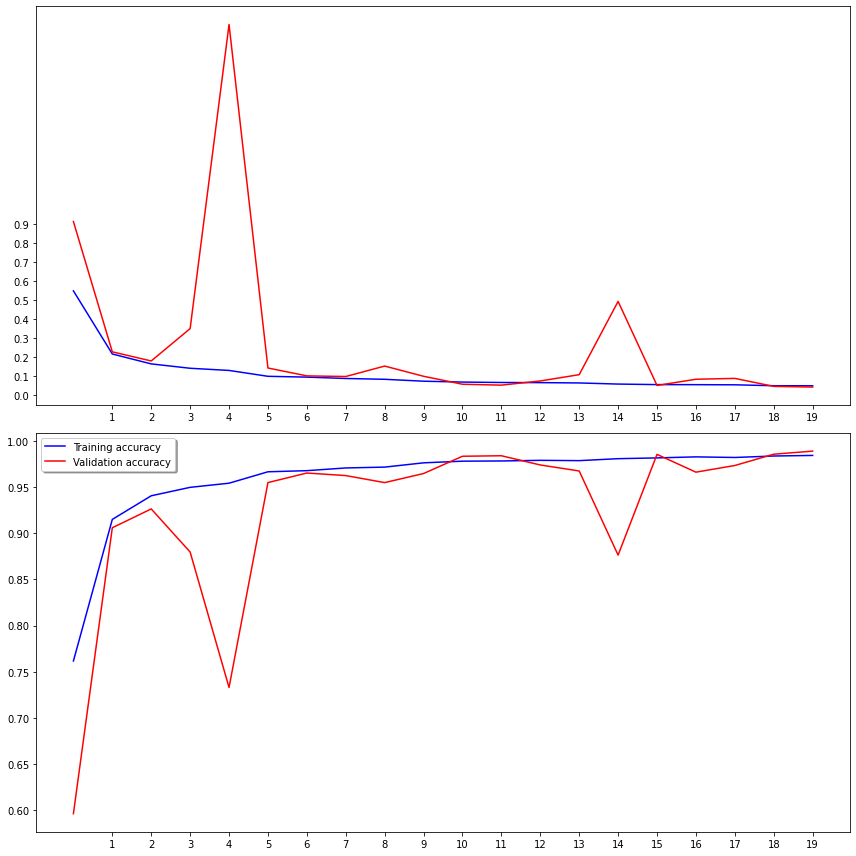

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [19]:
model.load_weights("model_20_eps_resample_final.h5")

In [21]:
Y_pred = model.predict_generator(validation_generator, total_validate//batch_size+1 )
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[2645   25]
 [  36 2715]]


In [22]:
pd.DataFrame(y_pred).to_csv('resample_cnn_pred.csv')

In [23]:
pd.DataFrame(df_validate).to_csv('resample_cnn_gt.csv')

In [23]:
print('Classification Report')
target_names = ['Defect', 'Good']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Defect       0.99      0.99      0.99      2670
        Good       0.99      0.99      0.99      2751

    accuracy                           0.99      5421
   macro avg       0.99      0.99      0.99      5421
weighted avg       0.99      0.99      0.99      5421



# Prepare Testing Data

In [24]:
test_filenames = os.listdir("data/test/test_contest/test")

test_df = pd.DataFrame({
    'id': test_filenames
})

nb_samples = test_df.shape[0]

In [25]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "data/test/test_contest/test", 
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 3830 validated image filenames.


# Predict

In [31]:
# model.load_weights("model_20_eps_resample.h5")

In [26]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [27]:
test_df['defect_score'] = predict[:,0]

# Submission

In [31]:
# from PIL import Image

# for i in range(len(test_df['defect_score'])):
#     origin_image = Image.open( 'data/test/test_contest/test/' + test_df['id'][i])
#     if(origin_image.size!=(275, 267)):
#         print(origin_image.size)
#         test_df['defect_score'][i]=1

In [32]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['id'].str.split('.').str[0]
submission_df.to_csv('final_20_epoch_resample_revised.csv', index=False)